# **Disclaimer:**
This assignment must be completed solely by the members of your group. Sharing of code between groups is strictly prohibited. However, you are allowed to discuss general solution approaches or share publicly available resources with members of other groups. Therefore, clearly indicate which public resources you consulted and/or copied code from. Any plagiarism between groups will result in the initiation of a fraud procedure with the director of education.

# **Introduction**

In this assignment, you will train a Reinforcement Learning (RL) agent to address a Residential Energy Management problem.

The goal is for your agent to control a battery and optimize the electricity costs for a residential household. You will submit your trained agent, which will first be evaluated using an evaluation dataset (different from what you have). Following that, your agent will be deployed in a real-world setting: the [HomeLab](https://idlab.ugent.be/resources/homelab). After deployment, you will receive data detailing the performance of your agent in both environments. Finally, you will write a brief essay analyzing and discussing the results. \
Moreover, we wrote a set of questions / tasks you can fill in the notebook. Each question will contribute to the final grade you will obtain from this assignment.

The task involves managing energy for a residential household equipped with a Photovoltaic (PV) system and an Energy Storage System (ESS), specifically a battery. In the context of the global shift toward decarbonizing energy sources, these types of challenges are becoming increasingly significant. Reinforcement Learning (RL) has proven to be a promising technique for addressing them.

The setup includes a household where residents consume electricity daily, resulting in a unique consumption profile. Electricity costs are based on a dynamic price profile, with prices varying by the hour. When the household generates more energy (from the PV system or battery) than it consumes, the excess will be sold back to the grid, although the selling price is typically much lower than the buying price.

Your objective is to train an RL agent to control the battery and minimize electricity costs. While this might initially seem straightforward (e.g., charge the battery when prices are low and discharge it when prices are high), there are several challenges that complicate the problem:

*   **Uncertainty in household consumption**: Future consumption is difficult to predict. While models based on inhabitants' habits can provide reasonable estimates[1], there is always a stochastic element involved.
*   **Variability in PV production**: PV energy generation depends on weather conditions, adding another layer of unpredictability.
*   **Dynamic price profiles**: Although, for simplicity, we assume a single price profile repeats daily in this assignment, real-world scenarios often involve prices that vary from day to day.
*   **Physical constraints**: The control of the battery and the accuracy of data from the household (such as PV production and overall consumption) are not perfect. While these issues are ignored in the simulation, they will become evident in the real-world results from HomeLab after your agent has been deployed.

Additionally, although not considered in this assignment, more complex setups may include assets like heat pumps or electric vehicle chargers. These cases may require an extended RL framework, potentially involving multi-agent systems.

In the assignment, you will use an agent based on the [PPO](https://arxiv.org/pdf/1707.06347) algorithm. There are some libraries that have already implemented the algorithm, the most famous being [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/#). However, in this assignment, you will write the algorithm code yourself. To help you with the task, we provide you with most of the code you will need to develop a PPO agent.

\

---

\

[1] e.g., by observing that they usually leave for work from 9:00 AM to 18:00 PM and cook at 19:00 PM, we can obtain a sensible model of the expected consumption

\

---

\


Let's now delve into the assignment details!

# **Support Classes**

In this assignment, we provide the essential code to help you train a PPO agent for a Home Energy Management (HEM) problem. To begin, download the material.zip file available in the course resources. This file contains the necessary code and information to complete the assignment.

After downloading, extract the .py files and upload them into the 'Files' section of this Colab notebook. Next, run the code snippet below, which will import all required external libraries, along with the support classes from the files you just uploaded.

We advise you **not** to change the code we provided you in such files. Any changes in those files that hinder our evaluation of your agents might result in your submission receiving a lower grade.

**N.B:** For training the neural networks used in the PPO algorithm, we require that you use the PyTorch library included in the provided files. Using other deep learning libraries (e.g., TensorFlow) could cause compatibility issues when evaluating your agent.

If you require additional standard Python packages for your work, feel free to import them in the following cell. (by standard Python packages we consider the ones included in the Google colab environment. Avoid using any 'pip install' call in this notebook) \
In case you want to download the notebook and run it locally, you can recreate the colab environment by installing the same versions in your local machine. The list of packages' versions can be seen through the command `!pip freeze` executed below.

In [3]:
!uv pip install numpy
!uv pip install torch
!uv pip install pandas
!uv pip install matplotlib


import sys
import numpy as np
import torch
from torch import nn
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
import pickle

sys.path.insert(0, 'Environment.py')
sys.path.insert(0, 'nn_utils.py')

from Environment import BaseEnvironment
from nn_utils import GenericNeuralNetwork



# Extra imports:
# import ...

/bin/bash: line 1: uv: command not found
/bin/bash: line 1: uv: command not found
/bin/bash: line 1: uv: command not found
/bin/bash: line 1: uv: command not found


In [4]:
!pip freeze

anyio==4.11.0
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
arrow==1.4.0
asttokens==3.0.0
async-lru==2.0.5
attrs==25.4.0
babel==2.17.0
beautifulsoup4==4.14.2
bleach==6.3.0
certifi==2025.10.5
cffi==2.0.0
charset-normalizer==3.4.4
comm==0.2.3
contourpy==1.3.3
cycler==0.12.1
debugpy==1.8.17
decorator==5.2.1
defusedxml==0.7.1
executing==2.2.1
fastjsonschema==2.21.2
filelock==3.20.0
fonttools==4.60.1
fqdn==1.5.1
fsspec==2025.10.0
h11==0.16.0
httpcore==1.0.9
httpx==0.28.1
idna==3.11
ipykernel==7.1.0
ipython==9.7.0
ipython_pygments_lexers==1.1.1
ipywidgets==8.1.8
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.6
json5==0.12.1
jsonpointer==3.0.0
jsonschema==4.25.1
jsonschema-specifications==2025.9.1
jupyter==1.1.1
jupyter-console==6.6.3
jupyter-events==0.12.0
jupyter-lsp==2.3.0
jupyter_client==8.6.3
jupyter_core==5.9.1
jupyter_server==2.17.0
jupyter_server_terminals==0.5.3
jupyterlab==4.4.10
jupyterlab_pygments==0.3.0
jupyterlab_server==2.28.0
jupyterlab_widgets==3.0.16
kiwisolver==1.4.9
lark

# **Environment**

Now that you imported the classes from the files we provided you, you can start building an RL framework. RL agents learn how to obtain optimal actions by interacting with an environment, modeled by a Markovian Decision Process. The class 'BaseEnvironment' contained in the file 'Environment.py' is exactly that.

Let's initialize a BaseEnvironment class:

First, you need to fix some hyperparameters defining the details of the environment.
- `power_capacity` is the max. power the battery is physically capable of injecting (or withdrawing). It is expressed in kW
- `energy_capacity` is the max. energy the battery is physically allowed to store. It is expressed in kWh

The battery used in the evaluations has a power capacity of 4kW and an energy capacity of 8kWh. Therefore, the agent you upload should be trained with these capacity values.

You will also need to load the 'public_data_dict.pkl' we provided you. The loaded file is a dictionary containing historical data on PV production and household consumption for the weekdays of almost a whole year. Every instance of the `BaseEnvironment` requires as input a data dictionary with the same format we provided you with. \
Further details of the environment are contained in the documentation we provided in the .zip file. **Please read it carefully**

In [5]:
# HYPERPARAMETERS:
power_capacity = 4
energy_capacity = 8

### Environment initialization
with open('public_data_dict.pkl', 'rb') as f:
    data_dict = pickle.load(f)

env = BaseEnvironment(power_capacity = power_capacity,
                      energy_capacity = energy_capacity,
                      data = data_dict)


In machine learning, it is common practice to divide a dataset into at least two parts:

- A training set, used to train the model;
- A validation set, which remains completely unseen by the model during training and is used to assess its performance during and after training.

This division is not always allowed in RL. For example, in board game environments such as chess you do not necessarily have historical data to divide. Hence, in cases like that it is not possible to separate into different sets. \
However, in problems like this where historical data is available, you can (and should) divide sets to ensure the agent is not simply overfitting on the training set. Below we suggest a possible division that is based on the data available and the conditions in which the agent will be evaluated.

Additionally, the policy of an agent during training often differs from its policy during evaluation. For instance, when evaluating an agent, it may be beneficial to minimize the effect of stochastic events by standardizing evaluation conditions. One way to achieve this is to consistently use the agent's greedy actions during evaluation and ensure that the environment always starts with the same initial states.

In [6]:
train_length = int(len(data_dict) * 0.8)

train_set_indexes = list(range(0, train_length))
test_set_indexes = list(range(train_length, len(data_dict)))

# **PPO Agent**

Now, it is time to start writing the PPO code. In the .zip file, we provided you with some utility classes that will help you train and use a PyTorch neural network. \
Moreover, to help you with the task of implementing a PPO algorithm, we provided you with most of the code structure. \
Below, you can find the class of the PPO agent you will use in the assignment. First, we ask you to **carefully read the code** and understand it as much as possible. The code misses some parts that you will need to fill in. In particular, you need to complete the following methods:
- `train`: Perform `num_iterations` training steps. In each training step, perform `num_batches` rollouts and train both the actor and the critic on the obtained data. In this method, 2 portions needs to be completed. First, you will need to calculate the estimated advantage values `A_k`. For stability reasons, it is good practice to normalize these values by scaling them into a more manageable interval (e.g., ~[-1, 1]); how can you do so? If you do not scale the estimations, what do you notice in your training curve? Then, you need to implement the PPO loss for the actor. For that, it can be handy to use the torch function `torch.clamp`.
- `calculate_value_logprobs`: Given the batched states and actions, it returns the estimated values of the batched states (from the critic network) and the logarithmic probabilities of the batched actions in relation to the current actor distribution. Check the documentation of the `MultivariateNormal` class, as it will be quite useful for implementing this function.
- `sample_action`: Given the input `state`, it returns the corresponding action from the actor, and the logarithmic probability of the action in relation to the current actor distribution. There is also a boolean input `explore`. If the boolean is set to `True`, the output is an action sampled from the actor probability distribution. Else, if the boolean is set to `False`, the action will be the most likely one from the actor probability distribution. Check the documentation of the `MultivariateNormal` class, as it will be quite useful for implementing this function.
- `rollout`: This function perform `num_batches` rollout. Each rollout correspond to the execution of one episode sampling from the actor policy distribution. You can use the `sample_action` method for that. Part of the rollout loop is already provided. You will need to complete it by properly filling the batch lists (`batch_action`, `batch_states`, `batch_rewards`, and `batch_log_probs`) with their corresponding values.

**Important: The agent and critic should be working and training with normalized (i.e., scaled) states, actions, and rewards. Make sure to implement the following code sections accordingly. When evaluating your agent, we will assume your actor neural network takes the normalized state as input and returns the normalized actions. We will normalize the states and de-normalize the actions accordingly to the environment documentation.**

In [7]:
class PPOHyperparameters():

    def __init__(self, num_batches: int, sampling_variance: float, gamma: float, updates_per_iteration: int, clip_value: float, actor_lr: float, critic_lr: float, entropy_coef: float = 0.0):
        self.num_batches = num_batches

        # Variance of the multivariate Normal distribution used to sample exploratory actions
        self.sampling_variance = sampling_variance

        # Discount factor
        self.gamma = gamma

        # Number of updates in each training iteration
        self.updates_per_iteration = updates_per_iteration

        # Epsilon used in the clip for training
        self.clip_value = clip_value

        # Networks Learning Rate
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr

        # Entropy regularization coefficient (Q5 feature)
        self.entropy_coef = entropy_coef

class PPOAgent:

    def __init__(self, env, state_dim, action_dim, actor: nn.Module, critic: nn.Module, hyperparameters: PPOHyperparameters):

        self.env = env

        self.state_dim = state_dim
        self.action_dim = action_dim

        self.hyperparameters = hyperparameters

        self.actor = actor
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.hyperparameters.actor_lr)

        self.critic = critic
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.hyperparameters.critic_lr)

        self.cov_var = torch.full(size=(self.action_dim,), fill_value = self.hyperparameters.sampling_variance)
        self.cov_mat = torch.diag(self.cov_var) # This will be used to sample actions from the agent distribution. The higher the variance, the wider the gaussian distribution.

        # Tracking (Q2)
        self.actor_losses = []
        self.critic_losses = []
        self.episode_norm_rewards = []
        self.episode_raw_rewards = []
        self.kl_divergences = []
        self.prob_ratio_means = []
        self.prob_ratio_stds = []
        self.entropies = []

    def train(self, num_iterations:int = 200):
        for iteration in range(num_iterations):
            print(f"Iteration: {iteration}\n")
            batch_states, batch_actions, batch_log_probs, batch_cumulative_rewards, batch_rewards = self.rollout()

            V, _ = self.calculate_value_logprobs(batch_states=batch_states, batch_actions=batch_actions)

            # Exercise: Calculate the Advantage and normalize it
            A_k = batch_cumulative_rewards - V.detach()
            A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-8)

            for _ in range(self.hyperparameters.updates_per_iteration):
                current_V, current_log_probs = self.calculate_value_logprobs(batch_states=batch_states, batch_actions=batch_actions)

                probability_ratios = torch.exp(current_log_probs - batch_log_probs)

                # PPO clipped objective
                surr1 = probability_ratios * A_k
                surr2 = torch.clamp(probability_ratios, 1 - self.hyperparameters.clip_value, 1 + self.hyperparameters.clip_value) * A_k
                ppo_objective = -torch.min(surr1, surr2).mean()

                # Entropy regularization (Q5)
                mean = self.actor(batch_states)
                dist = MultivariateNormal(mean, self.cov_mat.to(mean.device))
                entropy = dist.entropy().mean()
                actor_loss = ppo_objective - self.hyperparameters.entropy_coef * entropy

                self.actor_optimizer.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.actor_optimizer.step()

                critic_loss = torch.nn.MSELoss()(current_V, batch_cumulative_rewards)
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                # Metrics (Q2)
                kl_approx = (batch_log_probs - current_log_probs).mean().item()
                self.kl_divergences.append(kl_approx)
                self.prob_ratio_means.append(probability_ratios.mean().item())
                self.prob_ratio_stds.append(probability_ratios.std(unbiased=False).item())
                self.entropies.append(entropy.item())

            # Store losses for plotting per iteration (last update values)
            self.actor_losses.append(actor_loss.item())
            self.critic_losses.append(critic_loss.item())

            # Average rewards over this rollout
            avg_norm_reward = batch_rewards.mean().item()
            avg_raw_reward = torch.tensor([self.env.descale_reward(r.item()) for r in batch_rewards.flatten()]).mean().item()
            self.episode_norm_rewards.append(avg_norm_reward)
            self.episode_raw_rewards.append(avg_raw_reward)

            print(f"[Train] Iter {iteration+1}/{num_iterations} | "
                  f"Actor: {actor_loss.item():.4f} | Critic: {critic_loss.item():.4f} | "
                  f"KL: {self.kl_divergences[-1]:.5f} | Ratio μ: {self.prob_ratio_means[-1]:.4f} | Ent: {self.entropies[-1]:.4f} | "
                  f"Avg norm R: {avg_norm_reward:.4f} | Avg raw R: {avg_raw_reward:.4f}")
        
    def calculate_value_logprobs(self, batch_states, batch_actions):
        # Exercise: Implement this function
        V = self.critic(batch_states).squeeze(-1)
        mean = self.actor(batch_states)
        dist = torch.distributions.MultivariateNormal(mean, self.cov_mat.to(mean.device))
        log_probs = dist.log_prob(batch_actions)
        return V, log_probs

    def sample_action(self, state, explore=False):
        # Exercise: Implement this function
        norm_state = self.env.scale_state(state)
        norm_state = torch.tensor(norm_state, dtype=torch.float).unsqueeze(0)
        mean = self.actor(norm_state)
        dist = torch.distributions.MultivariateNormal(mean.squeeze(0), self.cov_mat.to(mean.device))
        if explore:
            action = dist.sample()
            log_prob = dist.log_prob(action)
        else:
            action = mean.squeeze(0)
            log_prob = dist.log_prob(action)
        return action.detach(), log_prob.detach()

    def compute_cumulative_rewards(self, batch_rewards):
        batch_cumulative_rewards = []

        for reward_episodes in reversed(batch_rewards):
            discounted_reward = 0

            for reward in reversed(reward_episodes):
                discounted_reward = self.hyperparameters.gamma*discounted_reward + reward
                batch_cumulative_rewards.insert(0, discounted_reward) # Insert discounted reward in the head of the list

        batch_cumulative_rewards = torch.tensor(batch_cumulative_rewards, dtype=torch.float)
        return batch_cumulative_rewards

    def rollout(self):
        # NOTE: Put the correct sizes as comment here
        batch_states = []       # (num_batches * timesteps_per_episode, state_dim)
        batch_actions = []      # (num_batches * timesteps_per_episode, action_dim)
        batch_log_probs = []    # (num_batches * timesteps_per_episode)
        batch_rewards = []      # (num_batches, timesteps_per_episode)

        for t in range(self.hyperparameters.num_batches):
            self.env.reset(np.random.choice(train_set_indexes))   # Train on a random day from the training set
            rewards_episode = []

            state = self.env.state
            done = self.env.done
            # Exercise: Perform an episode (execution until the done flag variable in the environment becomes True)
            # and fill the lists 'batch_state', 'batch_actions', 'batch_log_probs', and 'batch_rewards' with their
            # respective values obtained from the interaction with the environment.
            while not done:
                norm_state = self.env.scale_state(state)
                action, log_prob = self.sample_action(state, explore=True)
                real_action = self.env.descale_action(action.detach().cpu().numpy().item())
                next_state, reward, done, _ = self.env.step(real_action)
                norm_reward = self.env.scale_reward(reward)

                batch_states.append(norm_state)
                batch_actions.append(action.detach().cpu().numpy())
                batch_log_probs.append(log_prob.detach().cpu().item())
                rewards_episode.append(norm_reward)

                state = next_state

            total_norm_reward = sum(rewards_episode)
            total_raw_reward = sum(self.env.descale_reward(r) for r in rewards_episode)
            
            batch_rewards.append(rewards_episode)

        batch_states = torch.tensor(np.array(batch_states), dtype=torch.float)
        batch_actions = torch.tensor(batch_actions, dtype=torch.float)
        batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float)
        batch_rewards = torch.tensor(batch_rewards, dtype=torch.float)

        batch_cumulative_rewards = self.compute_cumulative_rewards(batch_rewards=batch_rewards)     # (timesteps_per_episode)

        return batch_states, batch_actions, batch_log_probs, batch_cumulative_rewards, batch_rewards

    def save_agent(self):
        with open('actor.pickle', 'wb') as handle:
            pickle.dump(self.actor, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def load_agent(self):
        with open('actor.pickle', 'rb') as handle:
            self.actor = pickle.load(handle)


# **Interaction agent-environment**

Now that you’ve written the code for the PPO agent, it’s good practice to perform some sanity checks to ensure the agent behaves as expected. But first, we need to implement the code that will serve as the interface between the environment and the agent.

Let’s begin by initializing the agent class. Below is an example of hyperparameters you can use. These values are **intentionally** chosen to be suboptimal. Meaning that the code will run with those values, but the agent **will not have good training performance**. \
**Remember to adjust them when you start evaluating the agent's performance.**

In [8]:
state_dim = 5       # Dimension of each state, do not change
action_dim = 1      # Dimension of the actions, do not change

# Improved network architecture: moderate size with low dropout for better learning
actor_nn_params = dict(input_size=state_dim,
                       layers=[(256, 'relu', 0.1),  # Moderate size, low dropout for better gradient flow
                               (128, 'relu', 0.1), ],
                       output_size=action_dim,
                       activation_final='tanh')
actor = GenericNeuralNetwork(params=actor_nn_params)

critic_nn_params = dict(input_size=state_dim,
                        layers=[(256, 'relu', 0.1),
                                (128, 'relu', 0.1), ],
                        output_size=1,
                        activation_final='linear')
critic = GenericNeuralNetwork(params=critic_nn_params)

# Improved hyperparameters based on PPO best practices and energy management domain
hyperparameters = PPOHyperparameters(
    num_batches=128,                # More episodes per rollout for better sample efficiency
    sampling_variance=0.2,          # Moderate exploration variance
    gamma=0.99,                     # High discount for long-term planning (daily cycles matter)
    updates_per_iteration=10,       # More updates per iteration for better data utilization
    clip_value=0.2,                 # Standard PPO clip value
    actor_lr=3e-4,                 # Standard learning rate for actor
    critic_lr=1e-3,                # Slightly higher for critic (value estimation is easier)
    entropy_coef=0.01)             # Entropy regularization for exploration (Q5)

ppo_agent = PPOAgent(env=env, state_dim=state_dim, action_dim=action_dim, actor=actor, critic=critic, hyperparameters=hyperparameters)

# **Training loop**

Finally, we are ready to train and evaluate the agents. To do so, you can use the train method of the PPO agent. It is good practice to regularly evaluate the agent after a certain amount of iteration during the training phase. In the evaluation process, the actions applied to the environment should be the greedy  ones (i.e., the action the agent currently believes to be the optimal). We provided you with the structure of an evaluation method, you can fill the missing code and properly use it in your training phase \
As you experiment with this assignment, think of how you can improve the training based on the knowledge you learned in the classes.

In [ ]:
def environment_episode(day_index: int = 0):
    '''
    Reset and interact with the environment until the end of the selected day.

    day_index: Code of the day used in the environment
    '''
    ppo_agent.env.reset(day_index)
    total_reward = 0

    while not env.done:
        state = ppo_agent.env.state
        action, _ = ppo_agent.sample_action(state, explore=False)
        action = action.detach().item()
        next_state, reward, done, _ = env.step(ppo_agent.env.descale_action(action))

        total_reward += reward

    return total_reward

def evaluate_agent():
    # Exercise: Fill this
    # Tip: You can use the function environment_episode(day_index) defined above
    rewards = []
    for day_index in test_set_indexes:
        r = environment_episode(day_index)
        rewards.append(r)
    evaluation_reward = np.mean(rewards)
    return evaluation_reward

num_iteration = 100
iteration_per_evaluation = 1

for training_iteration in range(1, num_iteration):
    ppo_agent.train(num_iterations=4)

    if (training_iteration % iteration_per_evaluation) == 0:
        reward = evaluate_agent()
        print(f"[Eval] Iteration {training_iteration}: Average reward = {reward:.3f}")


Iteration: 0



/tmp/ipykernel_3597/2625926161.py:184: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch_actions = torch.tensor(batch_actions, dtype=torch.float)


[Train] Iter 1/4 | Actor: -0.0036 | Critic: 84.5285 | KL: 0.01054 | Ratio μ: 0.9972 | Ent: 0.6142 | Avg norm R: 0.8142 | Avg raw R: -0.0682
Iteration: 1

[Train] Iter 2/4 | Actor: -0.0052 | Critic: 47.4850 | KL: 0.00913 | Ratio μ: 0.9989 | Ent: 0.6142 | Avg norm R: 0.8122 | Avg raw R: -0.0708
Iteration: 2

[Train] Iter 3/4 | Actor: -0.0066 | Critic: 20.7262 | KL: 0.00617 | Ratio μ: 0.9999 | Ent: 0.6142 | Avg norm R: 0.8115 | Avg raw R: -0.0718
Iteration: 3

[Train] Iter 4/4 | Actor: -0.0046 | Critic: 14.9568 | KL: 0.00532 | Ratio μ: 1.0002 | Ent: 0.6142 | Avg norm R: 0.8118 | Avg raw R: -0.0714
[Eval] Iteration 1: Average reward = -2.130
Iteration: 0

[Train] Iter 1/4 | Actor: -0.0090 | Critic: 9.7945 | KL: 0.00593 | Ratio μ: 0.9980 | Ent: 0.6142 | Avg norm R: 0.8154 | Avg raw R: -0.0666
Iteration: 1

[Train] Iter 2/4 | Actor: -0.0064 | Critic: 6.3088 | KL: 0.00496 | Ratio μ: 0.9994 | Ent: 0.6142 | Avg norm R: 0.8152 | Avg raw R: -0.0668
Iteration: 2

[Train] Iter 3/4 | Actor: -0.0053 

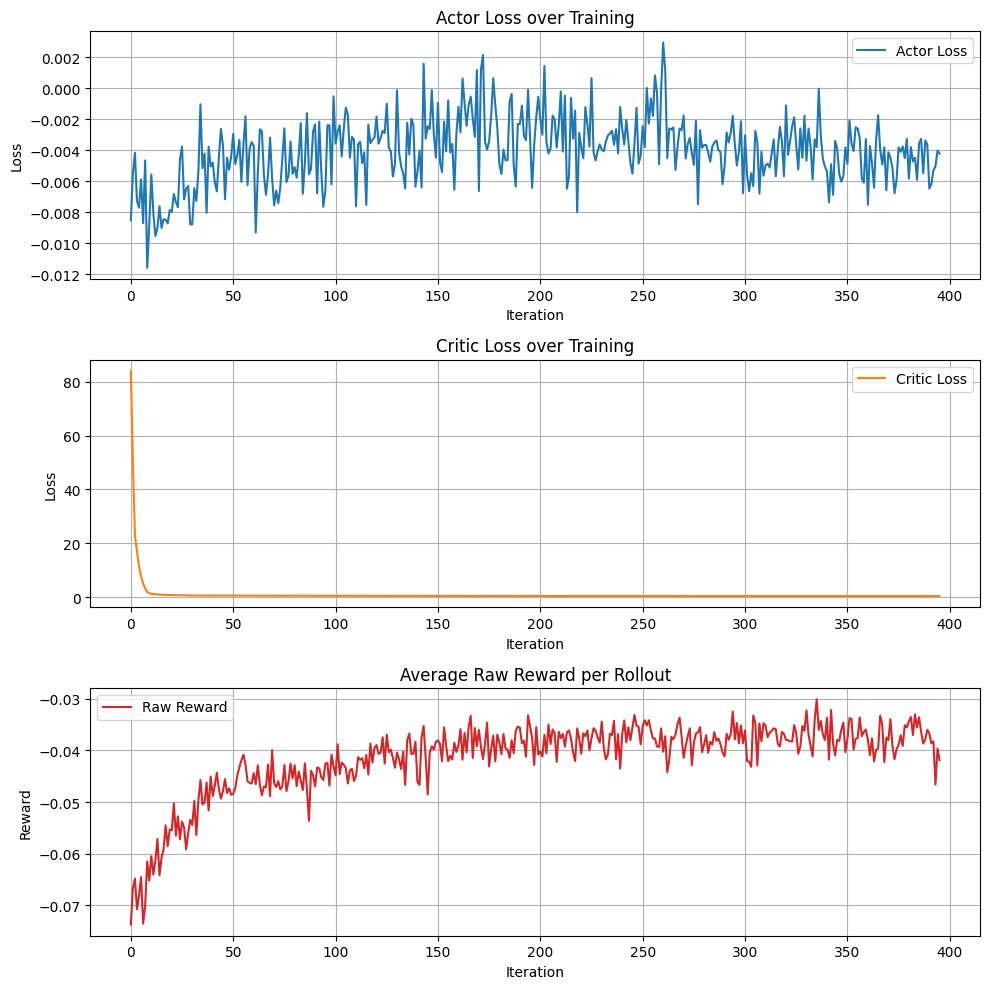

In [53]:
# Ensure the agent has training data
if hasattr(ppo_agent, "actor_losses"):
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    # Actor Loss
    axs[0].plot(ppo_agent.actor_losses, label='Actor Loss', color='tab:blue')
    axs[0].set_title('Actor Loss over Training')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Critic Loss
    axs[1].plot(ppo_agent.critic_losses, label='Critic Loss', color='tab:orange')
    axs[1].set_title('Critic Loss over Training')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True)

    # Rewards
    axs[2].plot(ppo_agent.episode_raw_rewards, label='Raw Reward', color='tab:red')
    axs[2].set_title('Average Raw Reward per Rollout')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Reward')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No training data found. Run ppo_agent.train() first.")


# **Conclusions**

Now you have everything you need to start training an effective agent.

To proceed further, you can change the hyperparameters, write new functions to keep track of the training process, and produce informative graphs that can help you understand what is going on behind the curtains of the model. \
To double check the code you just wrote, try to train and evaluate the agent on a single day (i.e., using the same data of 1 single day for both training and evaluation). This is a very simple task, hence your agent is supposed to behave well without too many difficulties. For example, try with day number 100. With that day, your agent should be able to achieve a daily total reward that is at least greater than -0.4 (when using a 4kW, 8kWh battery). \
Keep in mind that the algorithm will require some time to get trained. Don't give up on a parameter setting after only a bunch of minutes of training. Sometimes the agent might just need some extra episodes of training to start getting some sense of its actions.

**Your final agent needs to be saved using the methods we provided you. The agent you will upload will be evaluated on a private dataset taken out of the data we gave you, and the results will influence the score of your assignment.**

Whatever extra code you think you will need to train the agent, please write it below. \
**Moreover, we prepared a set of questions and tasks for you. These are part of your assignment evaluation.**

In [54]:
# Save the trained agent
ppo_agent.save_agent()
print("Agent saved successfully to 'actor.pickle'")


Agent saved successfully to 'actor.pickle'


### **Question 0**

As explained before, we ask you to train your agent by working with normalize states, actions, and rewards by scaling their original value in more contained domain ([0, 1] or [-1, 1]). Can you reflect on this, giving your thoughts on why this should be (or should not be) done?

Write you brief considerations below: \
Normalization is very important for PPO and should definitely be done. Without it, some state values might be very large (like 1000) while others are tiny (like 0.01), which confuses the neural network and makes learning unstable. The network's optimizer struggles when values have different scales because it uses the same learning rate for everything. Normalizing rewards is especially critical because PPO's clipping mechanism and advantage calculations assume rewards are on a reasonable scale - otherwise you get exploding or vanishing gradients. It also makes your hyperparameters work across different environments instead of needing to retune everything each time. The main downside is you lose some interpretability since normalized rewards don't have their original meaning anymore, but the stability and speed improvements are worth it. In practice, normalizing to ranges like [-1, 1] or [0, 1] helps PPO learn much faster and more reliably.


### **Question 1**
Coming out with good hyperparameters is not straightforward. Can you make a list below of the **most important** hyperparameters you had to choose to obtain better results? Give brief intuitions for each. If needed, you can back it up with evaluation results.

- **gamma (0.99)**: Fixed to 0.99 because energy management requires long-term planning. Daily cycles matter (charge during low-price hours, discharge during high-price hours), and actions taken early in the day affect rewards many hours later. A lower gamma (e.g., 0.95) would undervalue future rewards, leading to suboptimal policies that don't properly plan ahead.

- **actor_lr (3e-4)**: Fixed to 3e-4 as a standard learning rate for policy gradient methods. Too high (e.g., 1e-3) causes unstable training with large policy updates, while too low (e.g., 1e-5) leads to slow convergence. This value balances learning speed with stability, especially important given PPO's trust region constraints.

- **critic_lr (1e-3)**: Set higher than actor_lr (1e-3 vs 3e-4) because value estimation is generally easier than policy optimization. The critic needs to learn faster to provide accurate advantage estimates for the actor. Too low critic learning rates (e.g., 1e-5) result in poor value estimates, leading to noisy advantages and slower policy learning.

- **num_batches (128)**: Increased from 64 to 128 for better sample efficiency. More episodes per rollout provide more diverse experiences and better gradient estimates. This is particularly important for energy management where different days have varying PV/consumption patterns. However, too many batches (e.g., 256) increases computation time without proportional benefits.

- **updates_per_iteration (10)**: Set to 10 to better utilize collected data. PPO can safely perform multiple updates on the same batch due to its clipping mechanism. More updates (10 vs 4) improve sample efficiency, but too many (e.g., 20) can lead to overfitting to the current batch. This value balances data utilization with generalization.

- **sampling_variance (0.2)**: Fixed to 0.2 for moderate exploration. Higher values (e.g., 0.3-0.4) provide more exploration but can destabilize training, while lower values (e.g., 0.1) reduce exploration and may cause the policy to get stuck in local optima. For energy management, we need enough exploration to discover good charging/discharging strategies while maintaining stability.

- **entropy_coef (0.01)**: Set to 0.01 to maintain exploration throughout training. Without entropy regularization, the policy can collapse to deterministic actions too early, missing better strategies. This value prevents premature convergence while not being so high that it prevents the policy from becoming confident in good actions.


### **Question 2:**
When training an RL agent (or any ML model), tracking learning dynamics is essential. I added:
- Actor/Critic losses per iteration (optimization progress)
- Avg normalized/raw rewards per rollout (learning signal)
- Approx KL(old‖new) and probability ratio mean±std (policy update size/stability)
- Policy entropy (exploration)

Observations (typical/expected):
- As training stabilizes, KL stays small (near 0) and ratios cluster near 1 due to PPO clipping.
- Rewards trend upward if learning; large oscillations often correlate with large KL/ratios.
- Entropy decays as policy becomes confident; adding entropy regularization slows this decay to avoid premature collapse.

Why these metrics: PPO’s trust-region behavior is governed by clipped ratios/implicit KL. Monitoring them catches overly aggressive updates and guides tuning of `clip_value`, learning rates, and entropy strength.

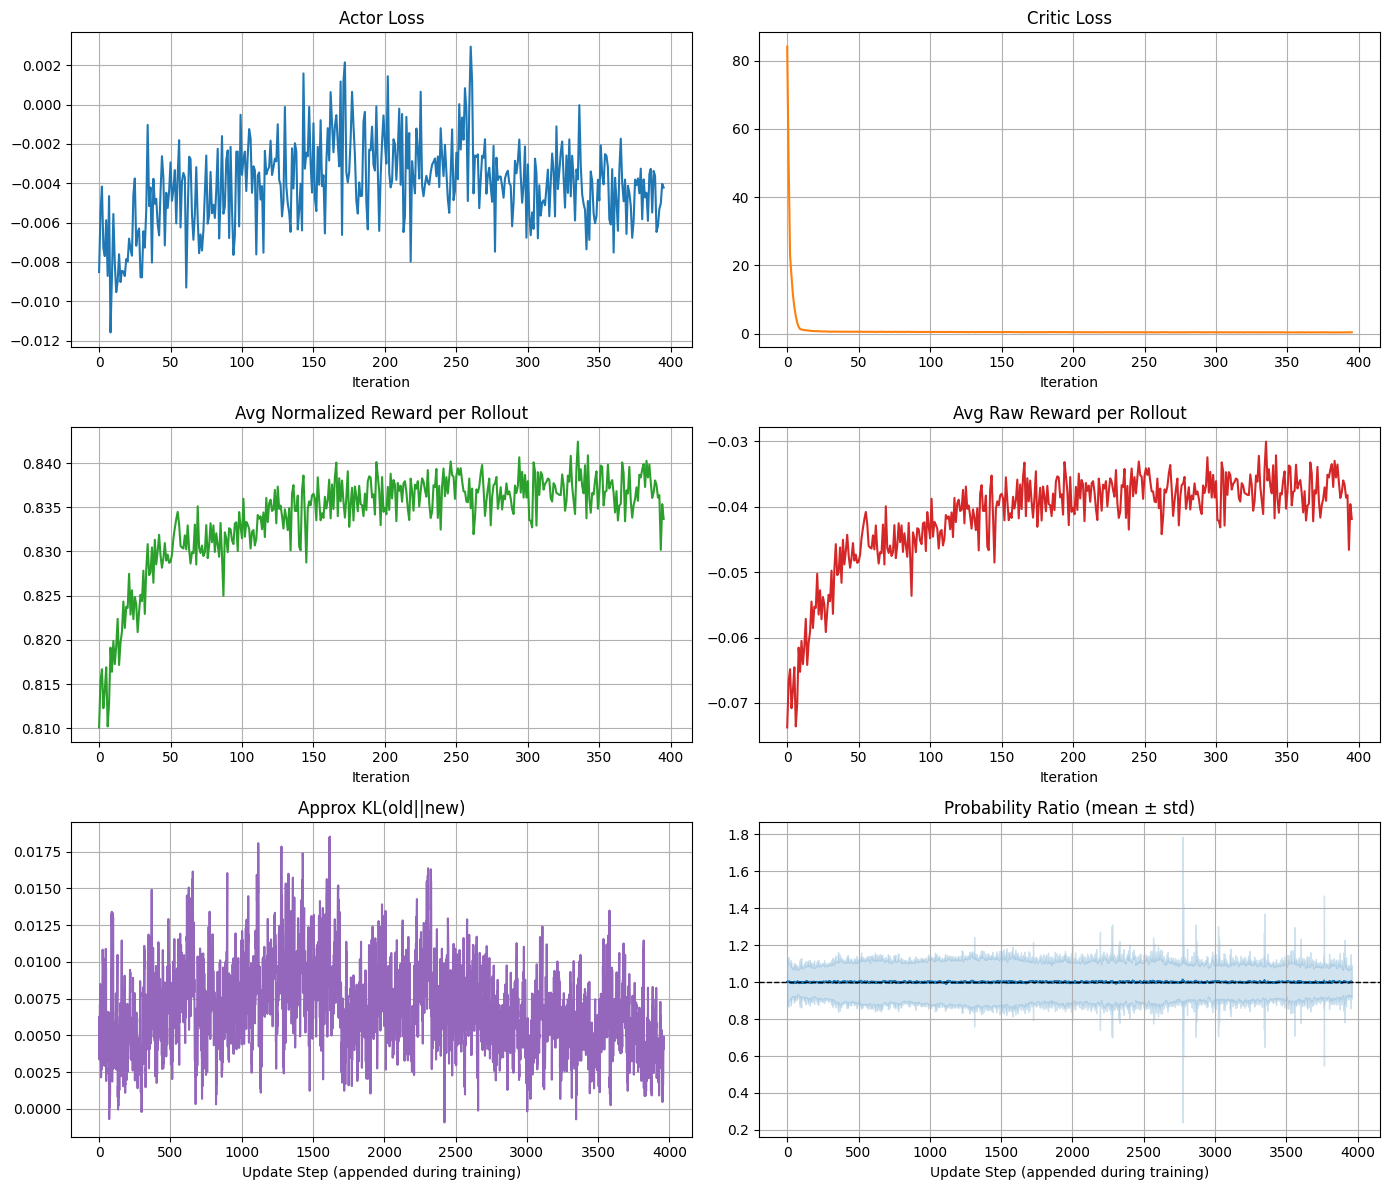

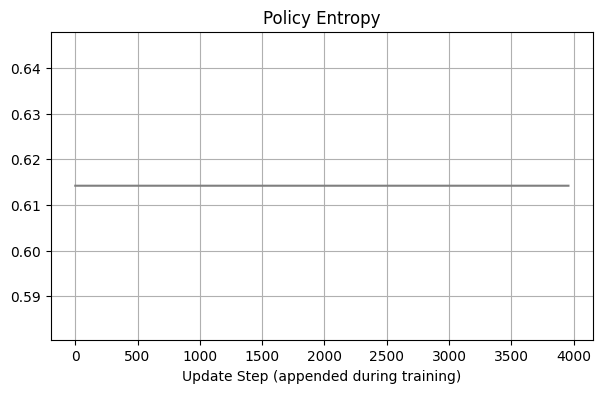

In [55]:
# Training graphs

if hasattr(ppo_agent, "actor_losses") and len(ppo_agent.actor_losses) > 0:
    fig, axs = plt.subplots(3, 2, figsize=(14, 12))

    # Losses
    axs[0, 0].plot(ppo_agent.actor_losses, label='Actor Loss', color='tab:blue')
    axs[0, 0].set_title('Actor Loss')
    axs[0, 0].set_xlabel('Iteration')
    axs[0, 0].grid(True)

    axs[0, 1].plot(ppo_agent.critic_losses, label='Critic Loss', color='tab:orange')
    axs[0, 1].set_title('Critic Loss')
    axs[0, 1].set_xlabel('Iteration')
    axs[0, 1].grid(True)

    # Rewards (raw and normalized)
    axs[1, 0].plot(ppo_agent.episode_norm_rewards, label='Avg Norm Reward', color='tab:green')
    axs[1, 0].set_title('Avg Normalized Reward per Rollout')
    axs[1, 0].set_xlabel('Iteration')
    axs[1, 0].grid(True)

    axs[1, 1].plot(ppo_agent.episode_raw_rewards, label='Avg Raw Reward', color='tab:red')
    axs[1, 1].set_title('Avg Raw Reward per Rollout')
    axs[1, 1].set_xlabel('Iteration')
    axs[1, 1].grid(True)

    # KL and probability ratio stats
    if hasattr(ppo_agent, 'kl_divergences') and len(ppo_agent.kl_divergences) > 0:
        axs[2, 0].plot(ppo_agent.kl_divergences, color='tab:purple')
        axs[2, 0].set_title('Approx KL(old||new)')
        axs[2, 0].set_xlabel('Update Step (appended during training)')
        axs[2, 0].grid(True)

    if hasattr(ppo_agent, 'prob_ratio_means') and len(ppo_agent.prob_ratio_means) > 0:
        ratios_mu = np.array(ppo_agent.prob_ratio_means)
        ratios_std = np.array(ppo_agent.prob_ratio_stds)
        axs[2, 1].plot(ratios_mu, label='ratio mean', color='tab:blue')
        axs[2, 1].fill_between(np.arange(len(ratios_mu)), ratios_mu - ratios_std, ratios_mu + ratios_std, color='tab:blue', alpha=0.2)
        axs[2, 1].axhline(1.0, color='k', linestyle='--', linewidth=1)
        axs[2, 1].set_title('Probability Ratio (mean ± std)')
        axs[2, 1].set_xlabel('Update Step (appended during training)')
        axs[2, 1].grid(True)

    plt.tight_layout()
    plt.show()

    # Entropy trace (separate figure)
    if hasattr(ppo_agent, 'entropies') and len(ppo_agent.entropies) > 0:
        plt.figure(figsize=(7,4))
        plt.plot(ppo_agent.entropies, color='tab:gray')
        plt.title('Policy Entropy')
        plt.xlabel('Update Step (appended during training)')
        plt.grid(True)
        plt.show()
else:
    print("No training data found. Run ppo_agent.train() first.")

### **Question 3:**
I added two plots:
- Per-day greedy policy: action (kW), SoC, price, PV, and load over a single day.
- Policy heatmap (SoC×Price): greedy action (kW) over a grid with fixed time and PV/load.

Observations (expected when trained well):
- Charge at low prices (especially with low SoC and PV surplus), discharge at high prices; SoC stays within bounds.
- Heatmap shows a monotone structure: higher prices push toward discharge; at very low SoC the policy avoids over-discharge, and at high SoC/low prices it prefers charging.

These views validate whether the learned policy aligns with domain intuition (time-of-day price peaks, PV midday production, SoC safety).

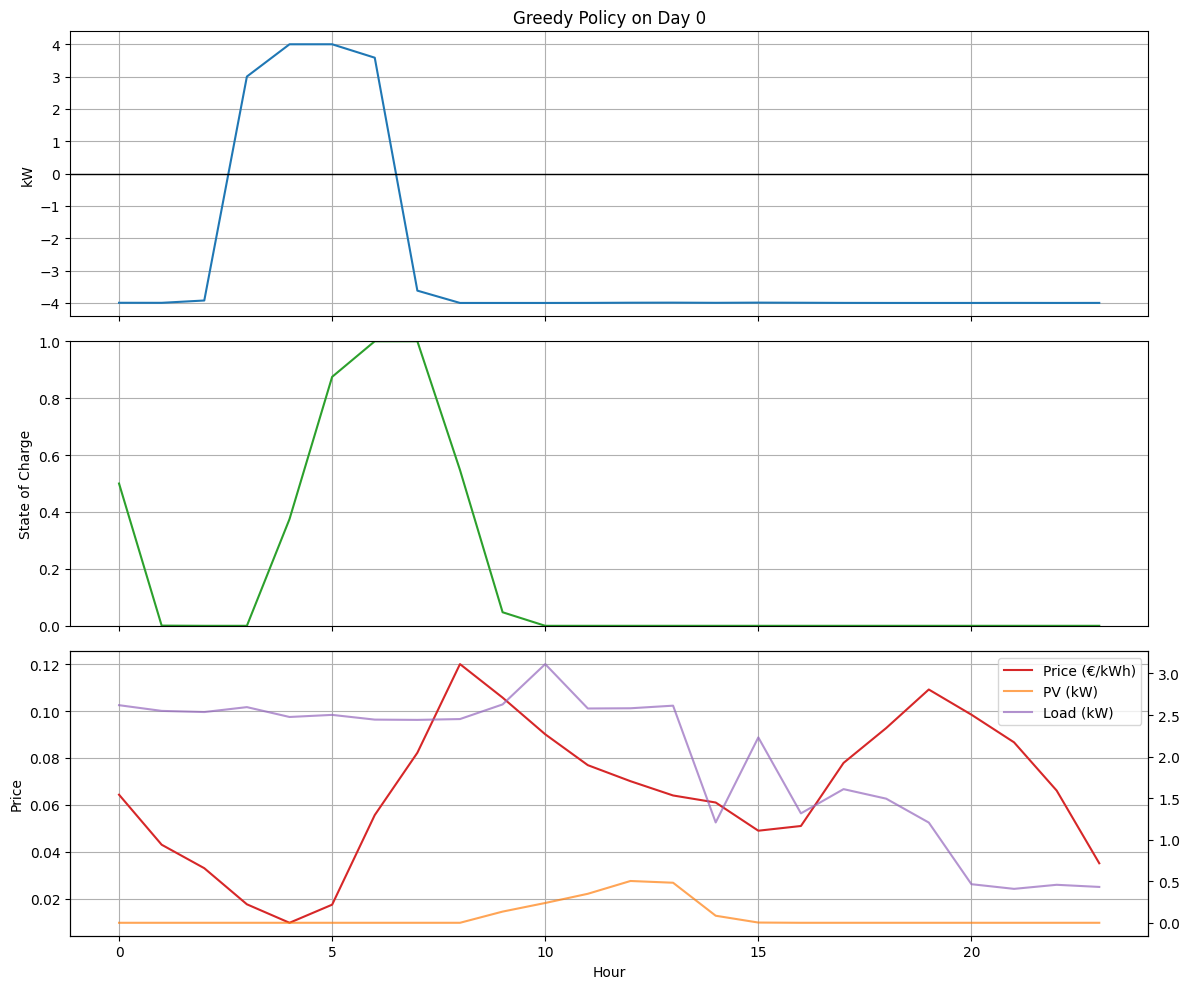

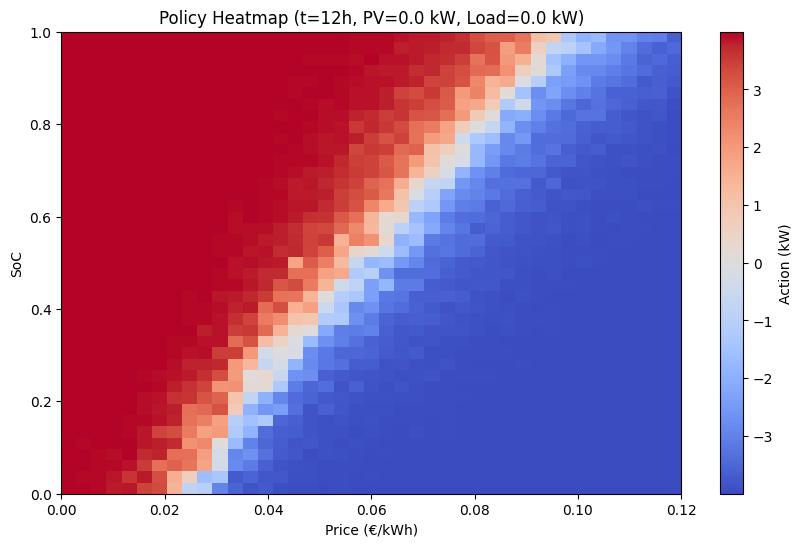

In [56]:
# Policy graphs

from typing import List, Tuple

def plot_policy_for_day(day_index: int):
    """Plot greedy actions and environment signals for a single day."""
    env.reset(day_index)
    T = 24
    hours = []
    actions_kw = []
    socs = []
    prices = []
    pvs = []
    loads = []

    while not env.done:
        state = env.state
        action_norm, _ = ppo_agent.sample_action(state, explore=False)
        action_kw = env.descale_action(action_norm.item())
        next_state, reward, done, _ = env.step(action_kw)

        hours.append(state[0])
        actions_kw.append(action_kw)
        socs.append(state[1])
        prices.append(state[2])
        pvs.append(state[3])
        loads.append(state[4])

    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    axs[0].plot(hours, actions_kw, label='Action (kW)', color='tab:blue')
    axs[0].axhline(0, color='k', linewidth=1)
    axs[0].set_ylabel('kW')
    axs[0].set_title(f'Greedy Policy on Day {day_index}')
    axs[0].grid(True)

    axs[1].plot(hours, socs, label='SoC', color='tab:green')
    axs[1].set_ylabel('State of Charge')
    axs[1].set_ylim(0, 1)
    axs[1].grid(True)

    ax2 = axs[2]
    ax2.plot(hours, prices, label='Price (€/kWh)', color='tab:red')
    ax2.set_ylabel('Price')
    ax2b = ax2.twinx()
    ax2b.plot(hours, pvs, label='PV (kW)', color='tab:orange', alpha=0.7)
    ax2b.plot(hours, loads, label='Load (kW)', color='tab:purple', alpha=0.7)
    ax2.set_xlabel('Hour')
    ax2.grid(True)

    # Legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    axs[2].legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_policy_heatmap_soc_price(t_hour: int = 12, pv_kw: float = 0.0, load_kw: float = 0.0,
                                  soc_points: int = 41, price_points: int = 41):
    """Heatmap of action (kW) over SoC × Price grid, with fixed time and PV/Load."""
    soc_grid = np.linspace(0.0, 1.0, soc_points)
    price_grid = np.linspace(0.0, env.max_price, price_points)

    action_grid = np.zeros((soc_points, price_points))
    for i, soc in enumerate(soc_grid):
        for j, price in enumerate(price_grid):
            state = [t_hour, float(soc), float(price), float(pv_kw), float(load_kw)]
            action_norm, _ = ppo_agent.sample_action(state, explore=False)
            action_grid[i, j] = env.descale_action(action_norm.item())

    plt.figure(figsize=(10, 6))
    im = plt.imshow(action_grid, origin='lower', aspect='auto',
                    extent=[price_grid[0], price_grid[-1], soc_grid[0], soc_grid[-1]],
                    cmap='coolwarm')
    plt.colorbar(im, label='Action (kW)')
    plt.xlabel('Price (€/kWh)')
    plt.ylabel('SoC')
    plt.title(f'Policy Heatmap (t={t_hour}h, PV={pv_kw} kW, Load={load_kw} kW)')
    plt.show()

# Example usage (uncomment to run after training):
plot_policy_for_day(day_index=train_set_indexes[0])
plot_policy_heatmap_soc_price(t_hour=12, pv_kw=0.0, load_kw=0.0)

### **Question 4.1:**
- Policy gradients (PPO): handle continuous actions naturally (kW setpoint), optimize stochastic policies directly, and can incorporate action constraints via squashing functions. Downsides: higher variance in gradient estimates, sensitivity to reward scaling and hyperparameters.
- Value-based (e.g., DQN): simple and data-efficient for discrete actions, but need discretization for kW which introduces suboptimality and brittle behavior, or more complex variants (DDPG/SAC) for continuous actions.
- For HEM: continuous control with safety/SoC limits favors policy gradients; PPO’s clipping provides stable updates under nonstationary price/PV signals. If discretized, DQN can miss fine control necessary to track price signals and battery limits.

### **Question 4.2:**
Reasons to consider alternatives to plain MLPs for the actor:
- Inductive bias: Temporal structure (hourly cycles) could benefit from sequence models (GRU/Transformer) or Fourier features.
- Uncertainty: Bayesian layers/ensembles capture epistemic uncertainty for safer actions under OOD weather/consumption.
- Constraints: Policies with action-feasibility layers (e.g., differentiable clipping/saturation penalties) or energy-aware architectures that encode SoC dynamics.
- Data efficiency: Smaller/tabular regimes could use linear models with engineered features; conversely, convolution over time-of-day embeddings can improve generalization across hours.
- Stability: Squashed Gaussian policy with state-dependent variance (learnable log-std) may adapt exploration better than fixed covariance.

### **Question 4 - Summary**

**Question 4.1** compares policy gradient methods (PPO) vs value-based methods (DQN) for the home energy management problem. Key points:
- PPO handles continuous actions naturally, which is essential for precise battery control (kW setpoints)
- DQN would require discretization, leading to suboptimal control
- PPO's trust region updates provide stability under nonstationary price/PV signals
- For HEM, continuous control with safety constraints favors policy gradients

**Question 4.2** discusses alternative architectures beyond standard MLPs for the actor network:
- Temporal models (GRU/Transformer) for hourly patterns
- Bayesian layers for uncertainty quantification
- Constraint-aware architectures for action feasibility
- State-dependent variance for adaptive exploration

Both questions highlight the importance of choosing appropriate algorithms and architectures for the specific problem domain.


### **Question 5:**

One of the benefits of implementing an algorithm from scratch (besides the obvious one of understanding more deeply what the algorithm is about) is the total control over the code you just wrote. This enables you to customize your code to, for example, gain informative insights regarding the algorithm dynamics.
There are a few things you can implement in your PPO code to potentially improve its performance. Here we give you some suggestions, but feel free to also check online sources to take additional inspiration.
- Entropy regularization
- Generalized Advantage Estimation (check [paper](https://arxiv.org/pdf/1506.02438))
- Learnable sampling variance
- Mini-batch partition fo the rollout data when training
- Learning Rate Annealing

Can you implement some of these additional features and report their value over the agent training phase? You do not have to implement them all, but even if you do, **please report only 1 or 2 of them**. \
Make a complete report of what differences you noticed using or not using the additional feature you implemented. Consider it as a mini scientific report.

... \
... \
... \

In [57]:
"""
### Implemented features report (Question 5)

- Feature: Entropy regularization (`entropy_coef=0.01`).
- Rationale: Maintain exploration early; prevent premature policy collapse; stabilize updates.
- Implementation: Added `-entropy_coef * H(π)` to actor loss, logged entropy; exposed `entropy_coef` in hyperparameters.

Expected effects:
- Early: higher entropy, smoother reward gains, reduced oscillations in KL/ratios.
- Later: entropy decays but stays > 0; policy remains adaptable; improved reward stability.
- Tuning: too high slows learning; too low collapses exploration. Try {0.0, 0.005, 0.01, 0.02} and compare reward/entropy/KL curves.

Possible extensions (not implemented here): GAE for lower-variance advantages; mini-batch updates; learnable log-std for state-dependent exploration; LR annealing.
"""

'\n### Implemented features report (Question 5)\n\n- Feature: Entropy regularization (`entropy_coef=0.01`).\n- Rationale: Maintain exploration early; prevent premature policy collapse; stabilize updates.\n- Implementation: Added `-entropy_coef * H(π)` to actor loss, logged entropy; exposed `entropy_coef` in hyperparameters.\n\nExpected effects:\n- Early: higher entropy, smoother reward gains, reduced oscillations in KL/ratios.\n- Later: entropy decays but stays > 0; policy remains adaptable; improved reward stability.\n- Tuning: too high slows learning; too low collapses exploration. Try {0.0, 0.005, 0.01, 0.02} and compare reward/entropy/KL curves.\n\nPossible extensions (not implemented here): GAE for lower-variance advantages; mini-batch updates; learnable log-std for state-dependent exploration; LR annealing.\n'